In [242]:
import jieba
from jieba import analyse
import pandas as pd
import jieba.posseg as pseg
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

In [55]:
def GetTopX(df,X_str,s,number):
    number= 50
    s="。".join(df[X_str][:100].fillna("").values.tolist())
    return GetNounList(s,number)

def GetTopNoun(s,number):
    res = pseg.cut(s)
    dic = {}
    for w in res:
        if w.flag in ['n']:
            if w.word in dic:
                dic[w.word] += 1
            else:
                dic[w.word] = 1
                
    return sorted(dic.items(), key=lambda x:x[1],reverse=True)[:number]

def GetNounList(s,number):
    lis = []
    word_lis = GetTopNoun(s,number)
    for i in range(len(word_lis)):
        lis.append(word_lis[i][0])
    return lis

In [174]:
def AddWordFrequency2Df(df,number,row_number,Xstr,Xorder,lis):
    for ind, row in df.iterrows():
        row_s = row[Xstr]
        if isinstance(row_s, str):
            for word in lis:
                row_lis = GetTopNoun(row_s,row_number)
                try:
                    df.at[ind, str(Xorder)+"_"+word] = dict(row_lis)[word]
                except:
                    df.at[ind, str(Xorder)+"_"+word] = 0
        else:
            df.at[ind, str(Xorder)+"_"+word] = 0
    return df

In [182]:
def GetTunedX(full_df,df,Xstr_list,number_list,row_number_list):
    ori_Xlen = len(df.columns.values)
    for indx in range(len(Xstr_list)):
        lis = GetTopX(full_df,Xstr,s,number_list[indx])
        df = AddWordFrequency2Df(df,number_list[indx],row_number_list[indx],Xstr_list[indx],indx,lis)
    return df.iloc[:,ori_Xlen:].fillna(0)

In [256]:
def AddDummy(df,Dummystr):
    for ind,row in df.iterrows():
        if type(row[Dummystr]) is str:
            if row[Dummystr].startswith('9'):
                df.at[ind, 'dm_'+Dummystr] = 1
            else:
                df.at[ind, 'dm_'+Dummystr] = 0
        else:
            df.at[ind, 'dm_'+Dummystr] = 0
    return df['dm_'+Dummystr]

In [257]:
def GBCTextFit(full_df,df,Xstr_list,Ystr,number_list,row_number_list):
    global Dummystr
    df_X = GetTunedX(full_df,df,Xstr_list,number_list,row_number_list)
    df_X = pd.concat([df_X,AddDummy(df,Dummystr)],axis=1)
    df_Y = df[Ystr]
    gb_clf = GradientBoostingClassifier(n_estimators=500,learning_rate=0.1)
    gb_clf.fit(df_X, df_Y)
    return gb_clf

In [258]:
def RFTextFit(full_df,df,Xstr_list,Ystr,number_list,row_number_list):
    global Dummystr
    df_X = GetTunedX(full_df,df,Xstr_list,number_list,row_number_list)
    df_X = pd.concat([df_X,AddDummy(df,Dummystr)],axis=1)
    df_Y = df[Ystr]
    gb_clf = RandomForestClassifier(n_estimators=500)
    gb_clf.fit(df_X, df_Y)
    return gb_clf

In [265]:
## Input: df, string of X's, string of Y
df = pd.read_excel("山东_公司数据.xlsx",sheet_name="筛选过程")[:500]
Ystr = '是否是民营口腔医院\n或者诊所'
Xstr_list = ['公司名称','经营范围']
Dummystr = '统一社会信用代码'
number_list = [110,110]
row_number_list = [22,22]
acc_train = []
acc_test = []
train, test = train_test_split(df, test_size=0.2, random_state=2019)
for i in range(110,120,3):
    number_list[0]=i
    number_list[1]=i
    model=RFTextFit(df[:],train,Xstr_list,Ystr,number_list,row_number_list)
    test_X = GetTunedX(df[:],test,Xstr_list,number_list,row_number_list)
    test_X = pd.concat([test_X,AddDummy(test,Dummystr)],axis=1)
    acc_test.append(accuracy_score(test[Ystr], model.predict(test_X)).round(4))

c:\users\erin\appdata\local\programs\python\python36\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
c:\users\erin\appdata\local\programs\python\python36\lib\site-packages\pandas\core\indexing.py:480: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
c:\users\erin\appdata\local\programs\python\python36\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy

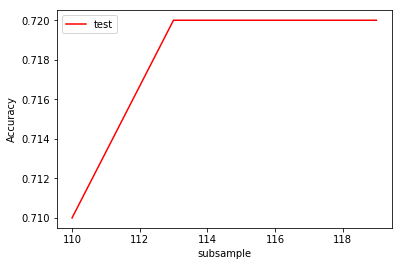

In [266]:
plt.figure()
plt.plot(range(110,120,3),acc_test,c='r',label='test')
plt.xlabel('subsample')
plt.ylabel('Accuracy')
plt.legend()
plt.show()